# 🔊 UrbanSound8K Classification (USC)

Welcome!

This notebook is for a school project at [Supinfo](https://www.supinfo.com/) Master grade in 2023 promotion, it covers the classification of sound from the [UrbanSound8K datasets](https://urbansounddataset.weebly.com/urbansound8k.html). 

Dans ce notebook, nous utiliserons des données comprenant des fichiers de sons au format [WAV](https://en.wikipedia.org/wiki/WAV) et leurs métadata correspondant dans un tableau csv. Dans ce projet nous aurons pour objectifs d'appréhender des notions théoriques relatives aux traitements de sons, et ainsi implémenter un modèle de classification.

En premier, nous allons charger et explorer l'ensemble données et méta-données de la dataset UrbanSound8K.
__#TODO__

En fin __#TODO__





## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa as lisa
import librosa.display

from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import StandardScaler

## 1. Exploration des données

In [2]:
df = pd.read_csv("/kaggle/input/urbansound8k/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
df.shape

(8732, 8)

*This file includes*

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID:
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

## 2. Librosa library

Librosa is a package for music and audio analysis. 

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6759664.svg)](https://doi.org/10.5281/zenodo.6759664)


- librosa.load : charger un fichier autio comme une série temporelle à virgule flottante.
- librasa.display.waveshow : ....

In [4]:
sound1, sampling_rate1 = lisa.load('../input/urbansound8k/fold5/100032-3-0-0.wav')
print("Shape :", sound1.shape)
print("Sampling rate: ", sampling_rate1)

Shape : (7002,)
Sampling rate:  22050


## 3. Format WAV


Le Waveform Audio File Format (WAVE, ou WAV en rapport avec son extension de fichier), est un format conteneur destiné au stockage de l'audio numérique mis au point par Microsoft et IBM. 

<img 
    style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 30%;"
    src="https://i.stack.imgur.com/Q9xGC.jpg" 
    alt="Canonical wave file structure">
</img>

### Headers
L'en-tête d'un fichier WAV contient plusieurs blocs. 
- En premier, nous avons le **bloc de déclaration**, qui fournit les information sur le fichier wav, comme son format et la taille du fichier. Ce bloc est hériter du RIFF. 
- Ensuite nous avons le **bloc d'écrivant le format audio**. Ce bloc est particulièrement intéressant car il fournit des information comme la fréquence d'échantillonage (en herzt) , le nombre de canaux (1 mono, 2 stéréo) et d'autres informations [wiki]().
- Enfin le **bloc de données**, ou sont stocké les octets des samples de chaque canal.


## 4. Quelques définitions

- **Frequence** : La fréquence est une caractéristique du son qui indique le nombre de vibrations par seconde exprimé en Hertz (Hz). $f= \frac{1}{T}$ $f$ : frequence (Hz) et $T$ : temps pour effectuer un cycle (s).
- **Amplitude** : La magnitude des alternances de pression acoustique, mesurée à partir de 0, est appelée amplitude.
- **Nombre de canaux** : Represente le canal utilisé. 1 pour Mono et 2 pour Stéréo.
- **Frequence d'echantillonage** : La fréquence d'échantillonnage utilisée en audio est le nombre d'échantillons pris par seconde pour enregistrer une piste audio. Il indique combien de fois par seconde l'audio est échantillonné lors de sa conversion de l'analogique au numérique.


## 5. Amplitude

En premier lieu, visualisons l'amplitude d'un echantillons de chacune des class et essayons d'en tirer une conclusion.

In [5]:
def format_filename(folder, filename):
    file_location = '../input/urbansound8k/fold{}/{}'.format(folder,filename)
    return file_location
    
def get_audio_file_by_classId(data,classId) :
    sample_data = data[data['classID'] == classId]
    sample_data = sample_data.reset_index()
    file_locations = []
    for index, row in sample_data.iterrows():
        file_location = format_filename(row['fold'], row['slice_file_name'])
        file_locations.append(file_location)
    return file_locations

def get_sample_by_classId(data, sample, classId):
    groups = data.groupby("classID").sample(sample)
    return get_audio_file_by_classId(groups,classId)

class_name = ( 
    "air_conditioner",
    "car_horn",
    "children_playing",
    "dog_bark", 
    "drilling",
    "engine_idling",
    "gun_shot",
    "jackhammer",
    "siren",
    "street_music"
)

def plot_amplitude(classId, sample):
    files = get_sample_by_classId(df,sample,classId)
    fig, ax = plt.subplots(nrows=sample,sharex='all', figsize=(20,10))
    for idx, file in enumerate(files) :
        s, sr = lisa.load(file)
        ax[idx].set_ylim(ymin=0)
        lisa.display.waveshow(s, sr=22050,ax=ax[idx])
    fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')
    plt.suptitle(f"ClassID : {class_name[classId]}", fontsize=14)
    plt.show()

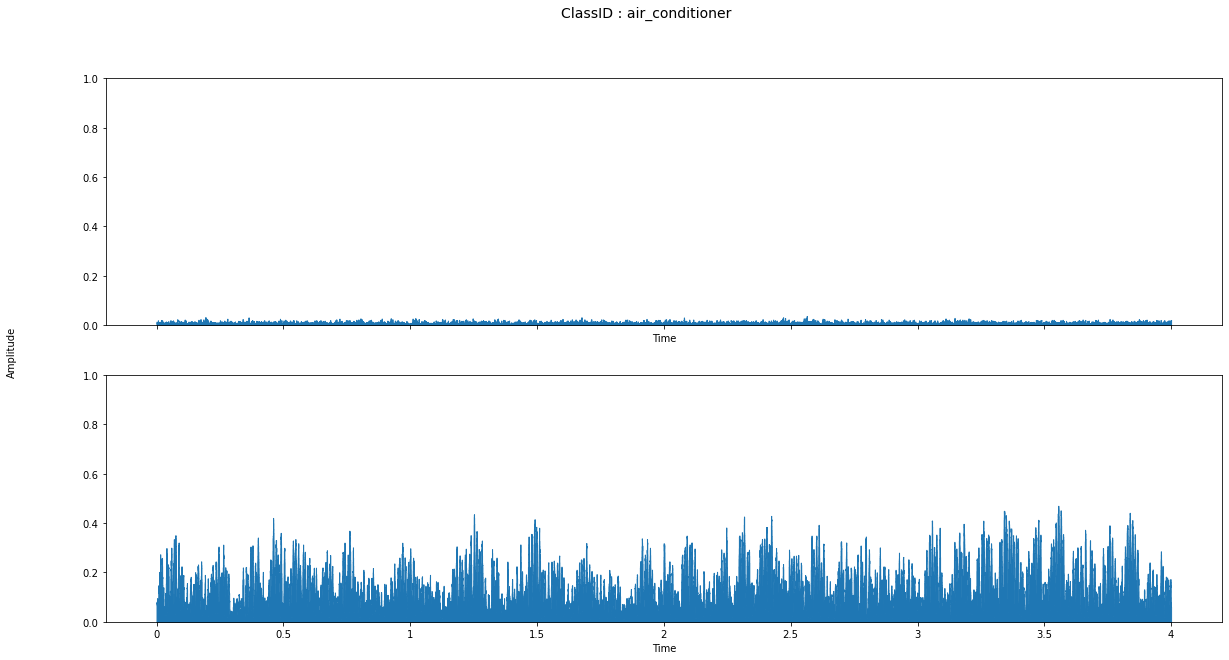

In [6]:
plot_amplitude(0,2)

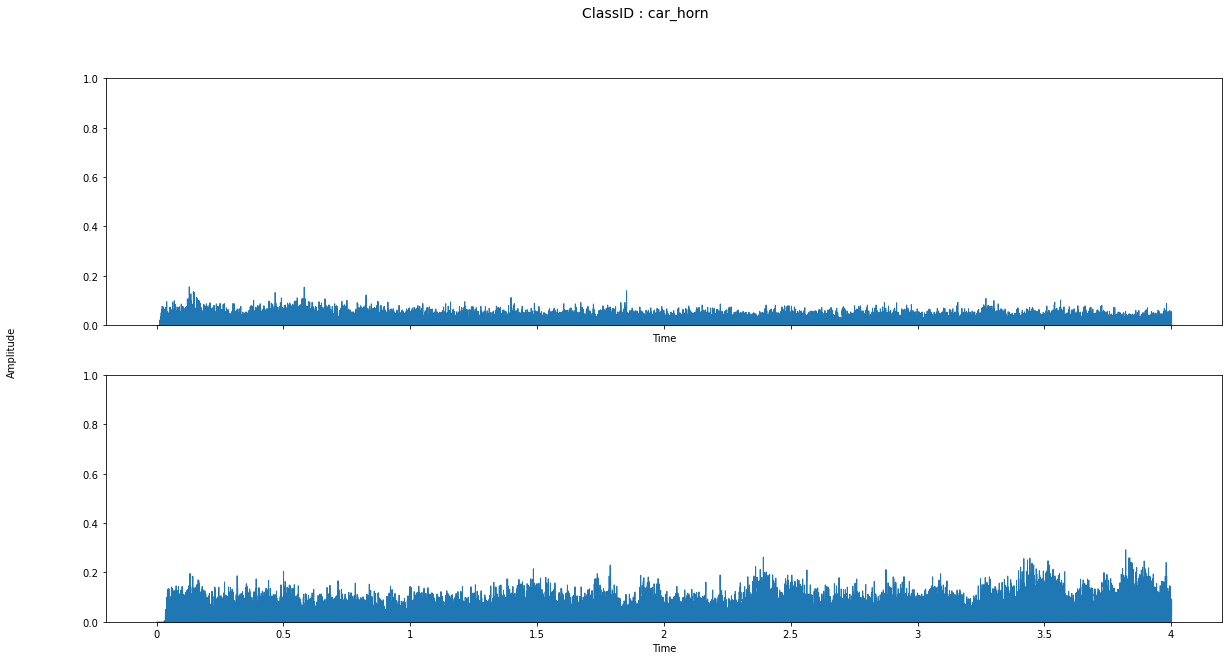

In [7]:
plot_amplitude(1,2)

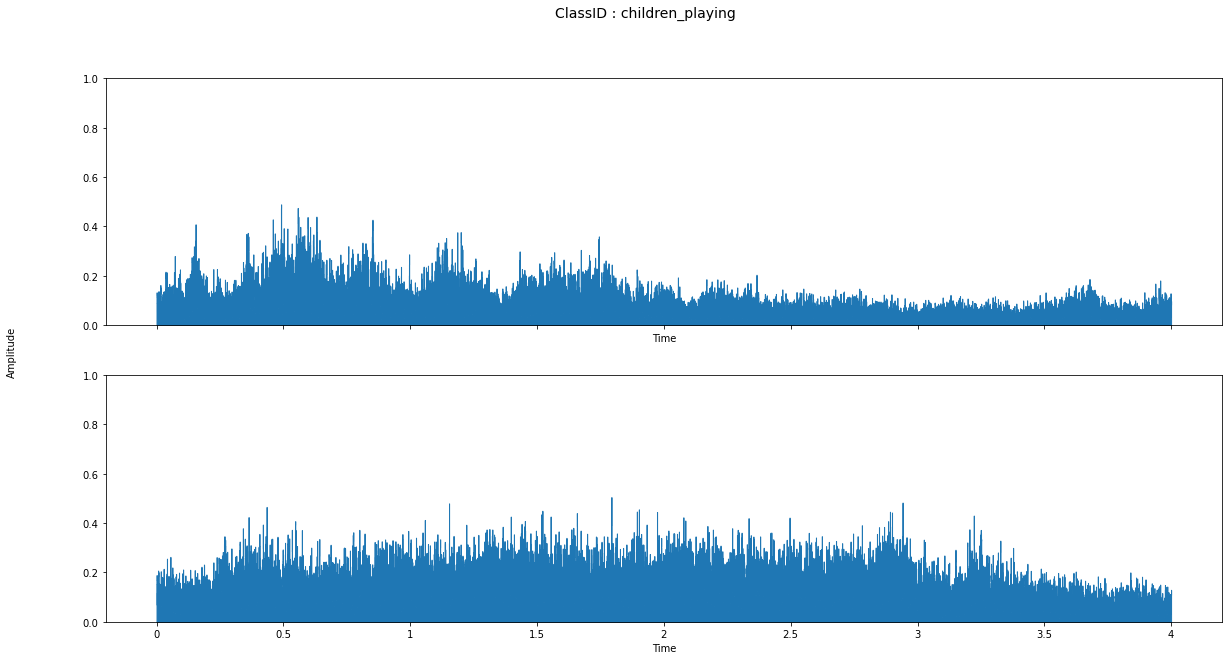

In [8]:
plot_amplitude(2,2)

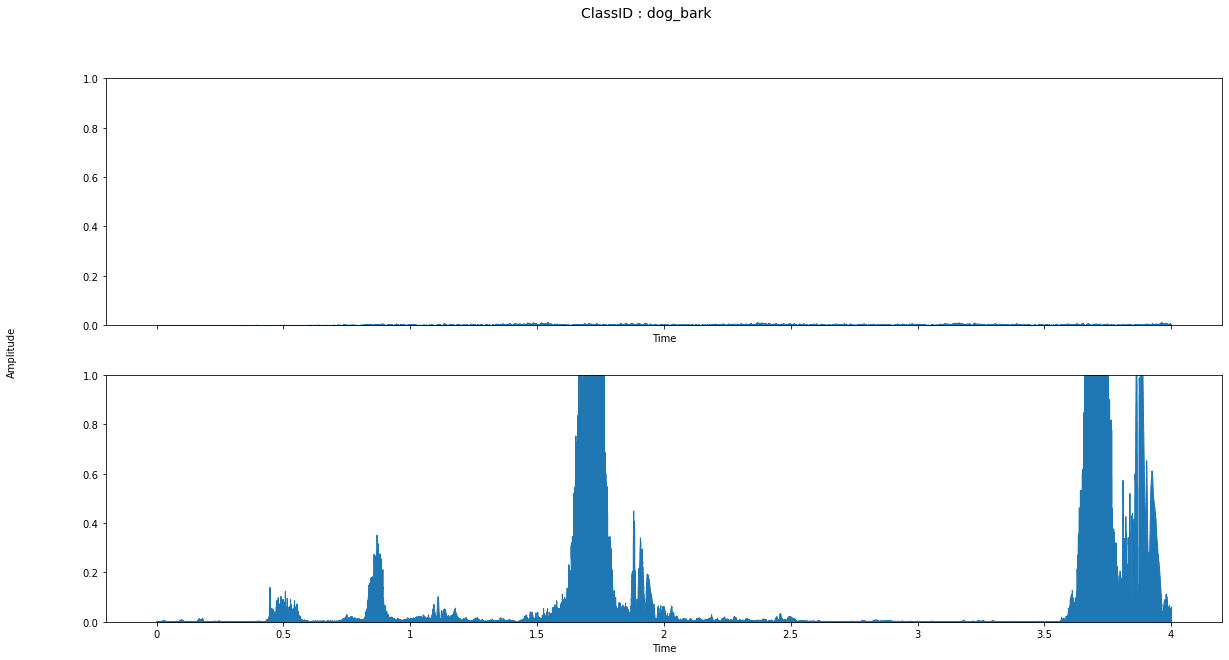

In [9]:
plot_amplitude(3,2)

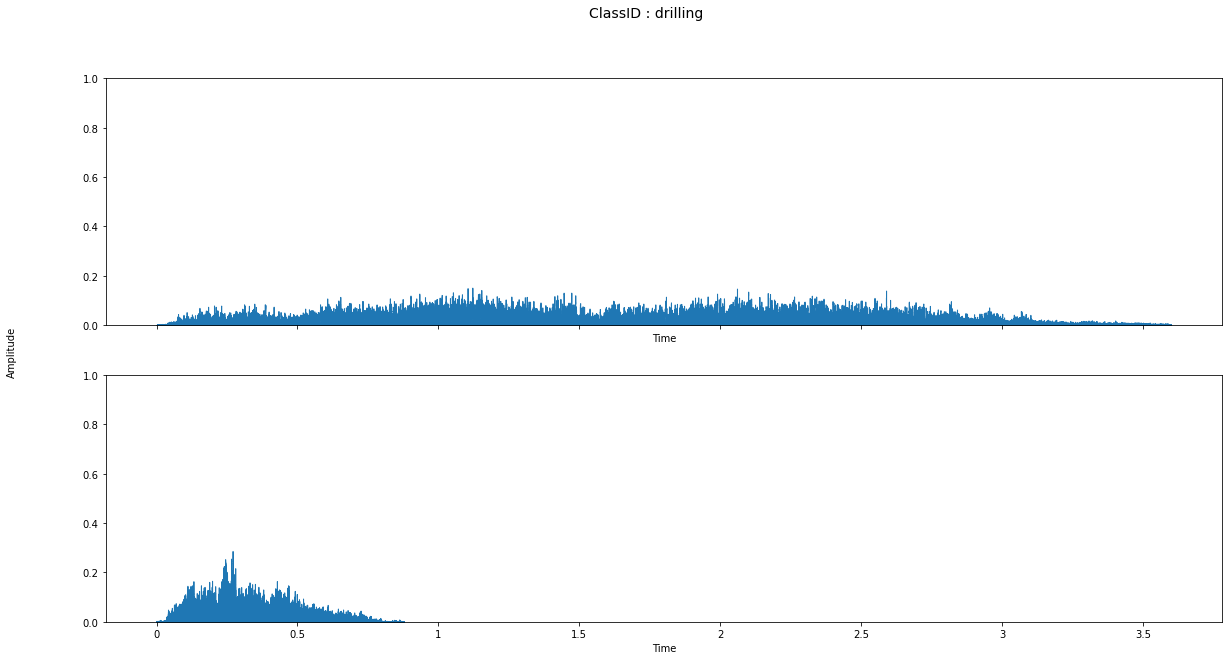

In [10]:
plot_amplitude(4,2)

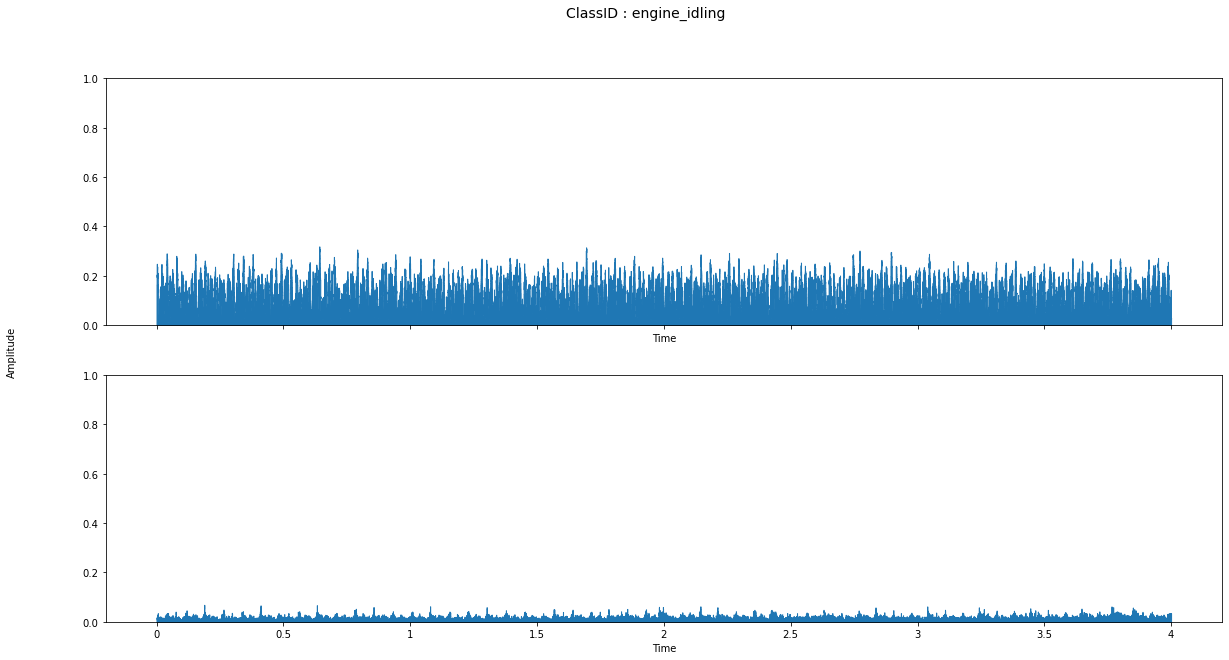

In [11]:
plot_amplitude(5,2)

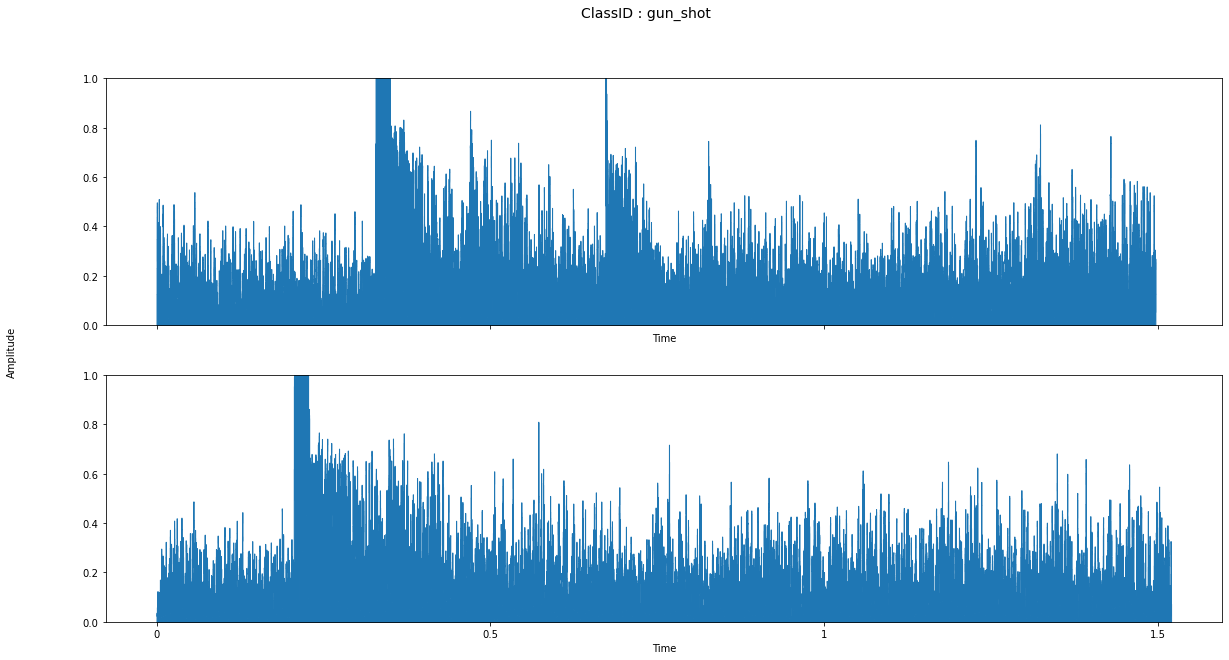

In [12]:
plot_amplitude(6,2)

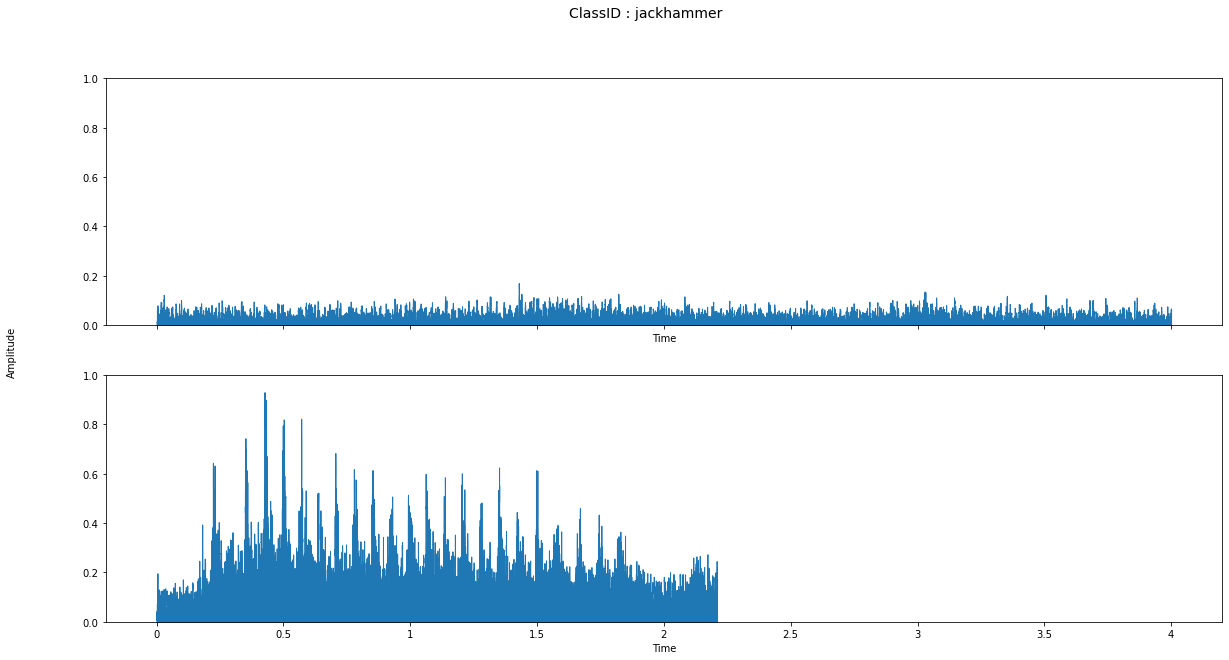

In [13]:
plot_amplitude(7,2)

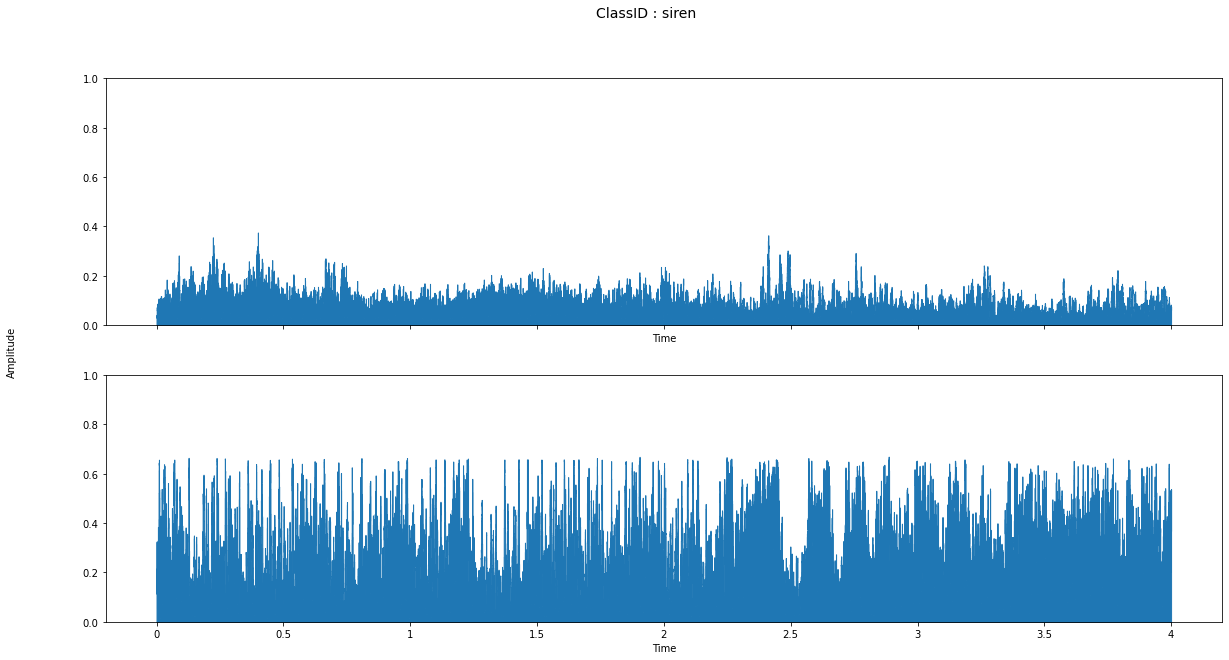

In [14]:
plot_amplitude(8,2)

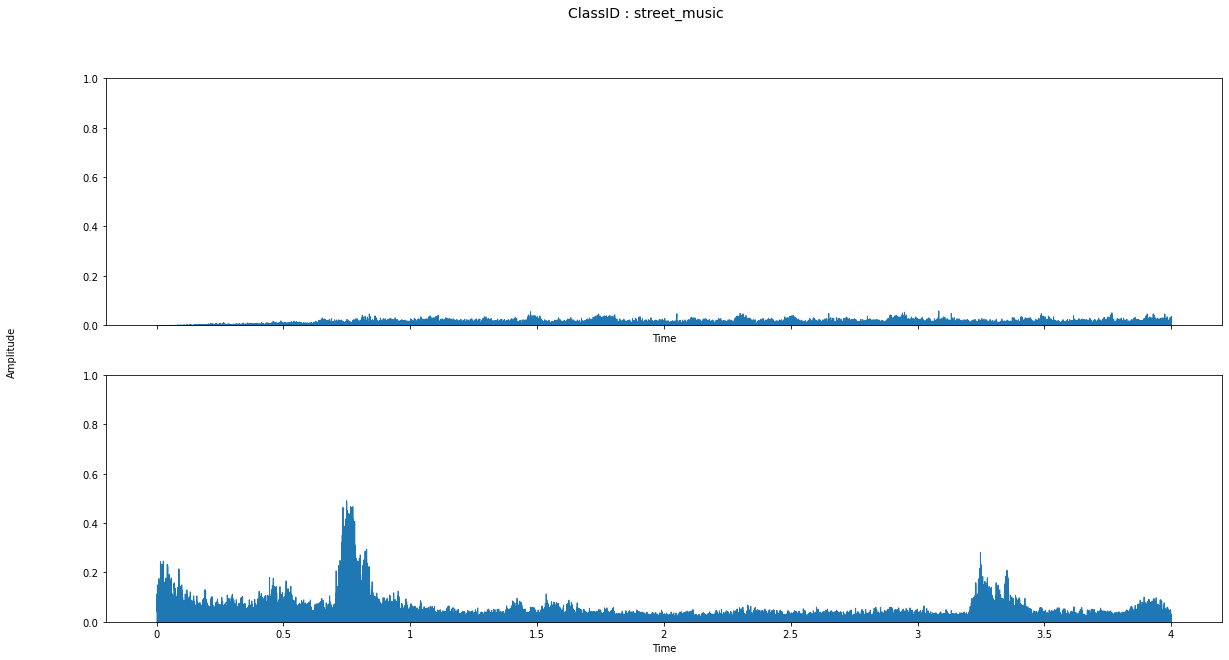

In [15]:
plot_amplitude(9,2)

**NOTES**

* Nous remarquons que les niveaux d'amplitude peuvent varier entre les échantillons d'une même classe.
* Ils peuvent également être similaires entre des classes différentes.
* L'amplitude sonore n'est pas une feature exploitable pour la classification car elle ne contient pas d'informations spécifiques permettant de différencier les différentes classes.


## 6. Dataset est-il équilibré ?



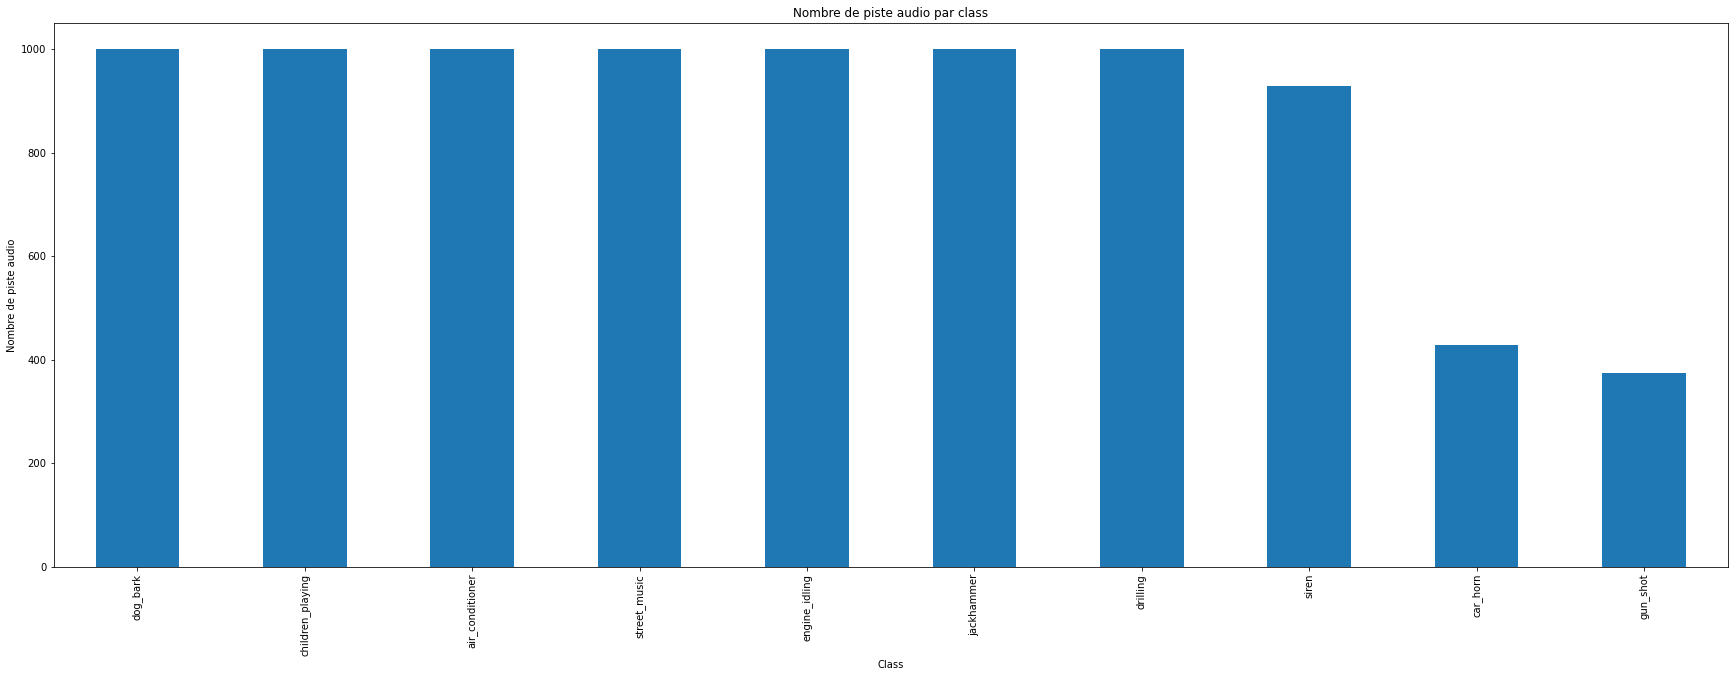

In [16]:
class_group = df['class'].value_counts()

plot = class_group.plot(
    kind='bar', 
    title="Nombre de piste audio par class", 
    figsize=(30,10)
)
plot.set_xlabel("Class")
plot.set_ylabel("Nombre de piste audio");

**NOTES**

* Nous remarquons que le nombre de pistes audio pour `car_horn` et `gun_shut` est inférieur à la moyenne.
* ... (Quelles métrics à utiliser pour évaluer la précision du modèle ?)
* ... (Comment y remedier ?) 
* ... (Ajuster la fonction coût ?)
* ... (Généraiton d'échantillon pour les classes minoritaires ?)

## 7. Distribution du nombre de canaux de chaque son

In [17]:
def get_more_infos_files(data):
    sounds = []
    for i in range(9):
        sounds_by_classID = data[data['classID'] == i]
        for index, row in sounds_by_classID.iterrows():
            s, sr = lisa.load('../input/urbansound8k/fold' + str(row['fold']) + '/' + row['slice_file_name'], sr=None, mono=False)
            sounds.append([row['slice_file_name'], row['fold'], row['classID'],'stereo' if s.shape[0] == 2 else 'mono', s.shape[0] if s.shape[0] == 2 else 1, s.shape[1] if s.shape[0] == 2 else s.shape[0], sr])
    return sounds

In [18]:
files_extend = get_more_infos_files(df)

In [19]:
df_files =  pd.DataFrame(np.array(files_extend,dtype=object), columns=['file_name', 'fold', 'classID', 'channel_type', 'n_channels', 'audio_time_series', 'sample_rate'])
df_files.head()

,file_name,fold,classID,channel_type,n_channels,audio_time_series,sample_rate
0,100852-0-0-0.wav,5,0,stereo,2,176400,44100
1,100852-0-0-1.wav,5,0,stereo,2,176400,44100
2,100852-0-0-10.wav,5,0,stereo,2,176400,44100
3,100852-0-0-11.wav,5,0,stereo,2,176400,44100
4,100852-0-0-12.wav,5,0,stereo,2,176400,44100


In [20]:
df_files[['n_channels','channel_type']].value_counts()

n_channels  channel_type
2           stereo          7048
1           mono             684
dtype: int64

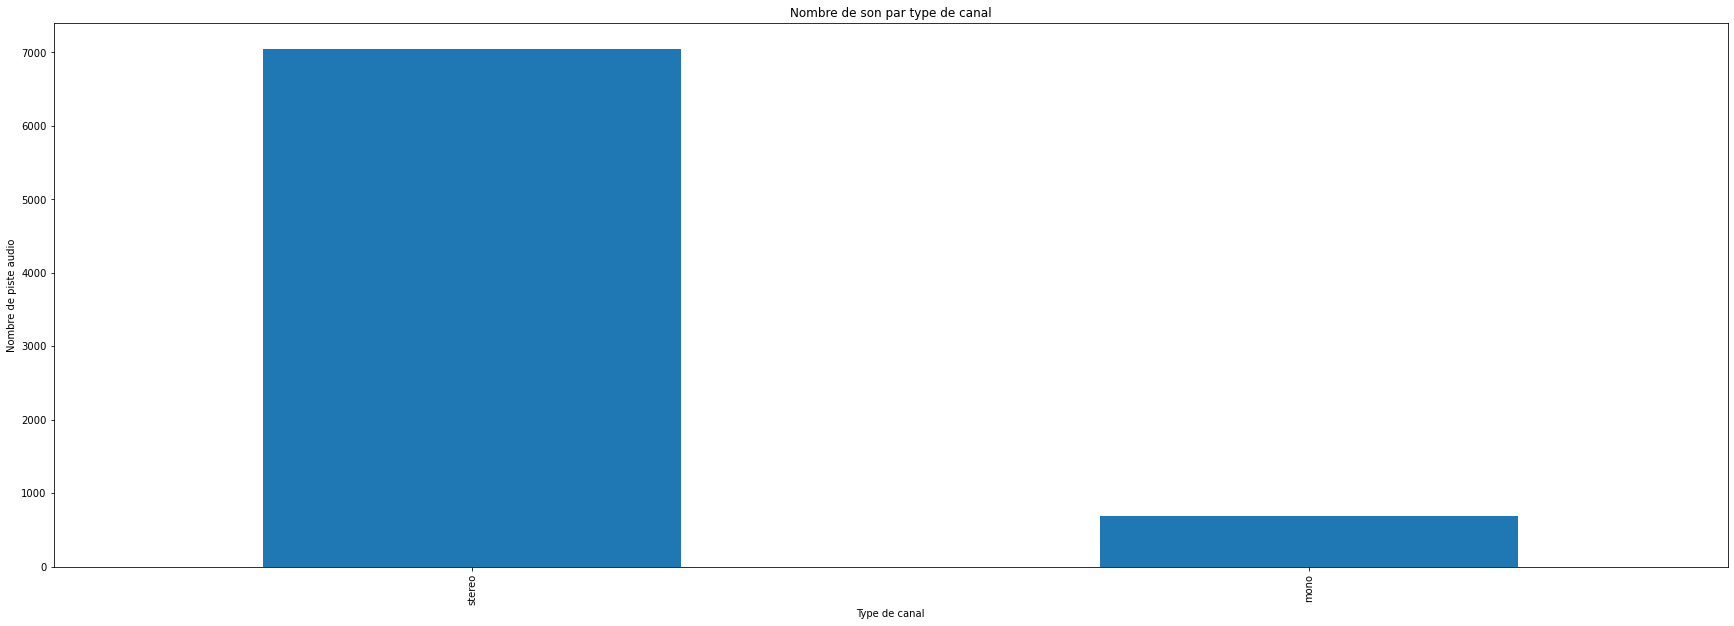

In [21]:
class_group = df_files['channel_type'].value_counts()

plot = class_group.plot(    
    kind='bar',     
    title="Nombre de son par type de canal",     
    figsize=(30,10))
plot.set_xlabel("Type de canal")
plot.set_ylabel("Nombre de piste audio");

**NOTES**

* La distributions du nombre de canaux est déséquilibré, avec une tendance supérieur pour le canal stéréo.
* ... ( Problèmes probables ? ) (Manque de précision lors de la classification)
* ... ( Solution probables ?  ) (Normalisation ?)

## 8. Distribution de la fréquence d'échantillonnage de chaque son

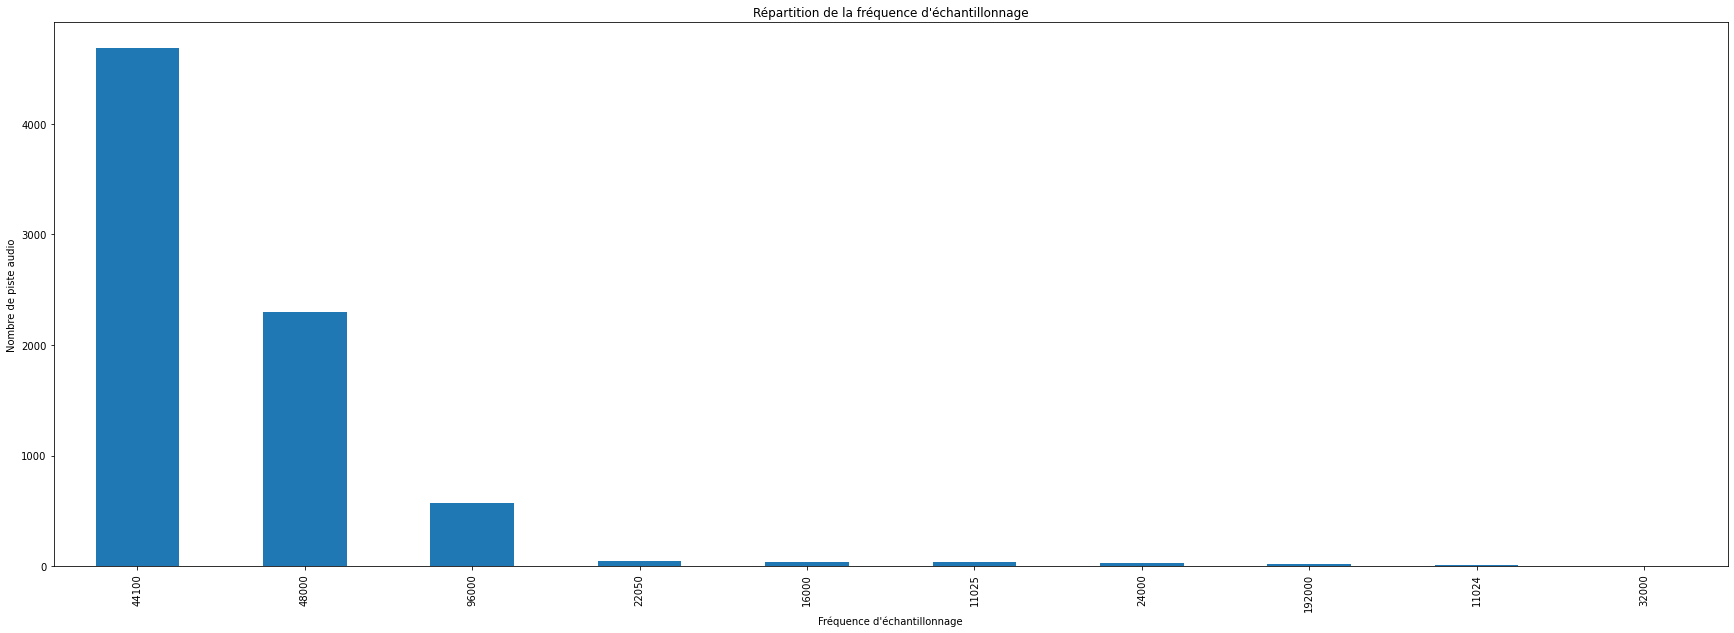

In [22]:
class_group = df_files['sample_rate'].value_counts()

plot = class_group.plot(    
    kind='bar',     
    title="Répartition de la fréquence d'échantillonnage",     
    figsize=(30,10))
plot.set_xlabel("Fréquence d'échantillonnage")
plot.set_ylabel("Nombre de piste audio");

**NOTES**
* La répartition de la fréquence d'échantillonnage est majoritaire pour la fréquence `44100` suivi de `40000`.
* Possible solution de normalisation 
    * Z-score(Standard scaler)
    * Normalisation avec la méthod **librosa.util.normalize** (A confirmer Simon)

In [23]:
# NOTES : Ceci est un test de normalisation à confirmer (SIMON)
data_sample_rate = df_files['sample_rate'].astype(float).values
data_sample_rate = data_sample_rate[np.isfinite(data_sample_rate)]
data_sample_rate_normalized = librosa.util.normalize(data_sample_rate)


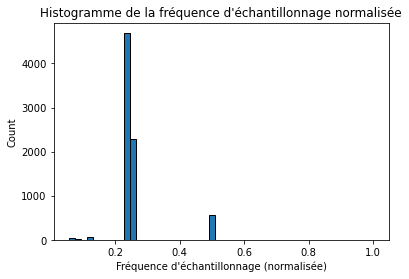

In [24]:
plt.hist(data_sample_rate_normalized, bins=50, edgecolor='k')
plt.xlabel("Fréquence d'échantillonnage (normalisée)")
plt.ylabel('Count')
plt.title("Histogramme de la fréquence d'échantillonnage normalisée")
plt.show()

## 9. Normalisation des variables étudiées par la librarie Librosa

Comme vu précédemment, les sons utilisés sont soit de type mono soit de type stéréo.

La librairie librosa nous permet de convertir les sons en mono.

La fonction utilisée est to_mono() qui fait la de la moyenne des échantillons entre les canaux.

Pour se faire nous passerons le paramètre mono de la fonction librosa.load à True.

Pour normaliser la fréquence d'échantillonnage de chaque son (Ou sample rate), nous allons utiliser le paramètre sr de la fonction load.

Cela nous permettra de définir le taux d'échantillonnage pour tous les sons.

## 10. “Mel-spectogram“ et “Mel-frequency cepstral coefficients“

(A reviser 😭, je sens trop de fautes, oui je sens 👀)


### Mel-spectogram / Log-Mel Spectrogram (LM) 
**Un spectrogramme mel** est un spectrogramme où les fréquences sont converties en échelle mel.

**L'échelle de Mel** est une échelle psychoacoustique de hauteurs des sons, au sens de leur repérage entre grave et aigu, dont l'unité est le mel. Le mel est relié au hertz (Hz). Il est calculé comme suit :

$$ Mel(f) = 295\log_{10} {(1 + \frac{f}{700})}$$

où $Mel(f)$ est l'échelle logarithmique de l'échelle de fréquence normale $f$. L'échelle Mel a un intervalle mel-fréquence constant, et couvre la gamme de fréquences de 0 Hz - 20050 Hz.

**Un spectrogramme** est une représentation visuelle de la distribution de l'énergie des fréquences dans un signal temporel. 
* Un spectrogramme est créé en divisant le *signal temporel* en segments, en transformant chaque segment en une représentation fréquentielle (telle qu'une **transformée de Fourier**), puis en utilisant une heatmap ou une image couleur pour représenter la distribution d'énergie pour chaque segment en fonction de la fréquence et du temps. 
* Les zones claires dans un spectrogramme indiquent des niveaux élevés d'énergie pour les fréquences correspondantes, tandis que les zones sombres indiquent des niveaux d'énergie plus faibles.

<img 
    style="display: block; 
           margin-left: auto;
           margin-right: auto;
           width: 30%;"
    src="https://miro.medium.com/max/1400/1*zX-rizZKXXg7Ju-entot9g.png" 
    alt="Mel-spectogram">
</img>


### Mel-frequency cepstral coefficients (MFCCs)

Les coefficients de cepstre fréquence de Mel (MFCC) sont un ensemble de caractéristiques qui, collectivement, constituent un Cepstre de fréquence mél (MFC). Ils sont générés en convertissant les fréquences en une échelle qui est plus en phase avec la perception humaine de la musique, puis en extrayant des coefficients de cepstre à partir de la transformée de Mel.

Les MFCC sont généralement calculés comme suit : 

1. Prendre la transformée de Fourier d'un signal (un extrait de celui-ci utilisé comme base de mesure).
2. Appliquer les puissances du spectre obtenu ci-dessus sur l'échelle mel, en utilisant des filtres à chevauchement triangulaire ou des filtres à chevauchement cosinus.
3. Prendre les logarithmes des puissances à chacune des fréquences mel.
4. Prendre la transformée en cosinus discrète de la liste des puissances logarithmiques du mel, comme s'il s'agissait d'un signal.
5. Les MFCC sont les amplitudes du spectre résultant.

$$C_n = \sqrt{\frac{2}{k}}\sum_{k=1}^{K}(\log{S_k})\cos{[n(k-0.5)\pi/k]}, n=1,2,...,N$$

où $S_k(k = 1, 2,... K)$ est la sortie du nombre de filtres et $N$ est le nombre total d'échantillons.

## 11. Construire un dataframe panda qui contiendra les MFCCs et les labels de chaque son.

### Exemple d'extraction MFCC

**Method**

Nous utiliserons des procédures de la librairie librosa.

1. Parcourir toutes les pistes audio en  normalisant :
   * *Le nombre de canaux* :`to_mono(...)` Mono. (Essayer d'autres canaux comme stéréo lors de l'apprentissage)
   * *Les fréquence d'échantillonnage* :`resample(...)` Methode de Fourier car le signal est périodique voir [scipy.signal.resample](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample), (Essayer plusieurs valeurs lors de l'apprentissage)
2. Extraction de la feature MFCCs :
    * *Param1* : le nombre de filtre de mels `n_mels`. (Essayer plusieurs valeurs lors de l'apprentissage) (entre 10 - 40) (Mésurer performance)
    * *Param2* : le mode de padding `pad_mode`. (Essayer plusieurs valeurs lors de l'apprentissage)
    * Paramn : ...
3. Ensuite On encodera les label en valeurs categorical (Cette étape pourra être fait sur en crean les transformer ? à voire)
4. Ensuite on rajoutera les valeurs MFCCs obtenues au dataframe qui seront nettoyer et reshape .

In [25]:
RATE = 44100                             # Définir la fréquence d'échantillonnage cible
N_MFCC = 12                              # Nombres de filtre de mels

files = get_sample_by_classId(df,1,6)    # Random fichier par class
y, sr = lisa.load(files[0])              # Chargment du fichier

print(f"Fichier ==> {files[0]}")

Fichier ==> ../input/urbansound8k/fold2/197320-6-9-0.wav


In [26]:
# Normalisation des canaux ou mono = True dans le load
y_mono = lisa.to_mono(y)

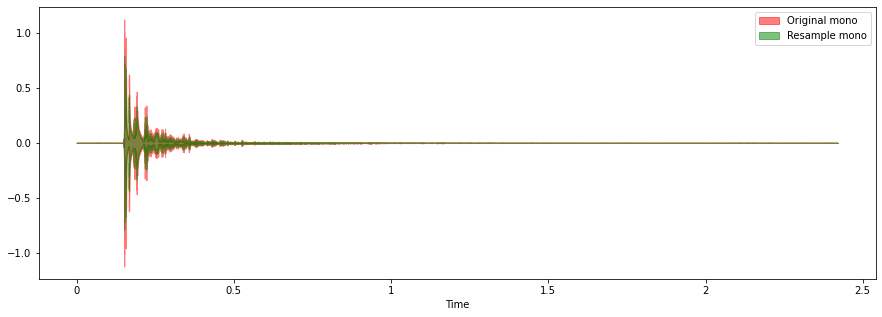

In [27]:
# Normalization sample rate 
y_rsmple = lisa.core.resample(y=y_mono,orig_sr=sr,target_sr=RATE, scale=True)

plt.figure(figsize=(15,5))
lisa.display.waveshow(y, sr=sr, color='r', label="Original mono", alpha=0.5 )
lisa.display.waveshow(y_rsmple, sr=RATE, color='g', label="Resample mono", alpha=0.5)
plt.legend()
plt.show()

[Text(0.5, 1.0, 'MFCC')]

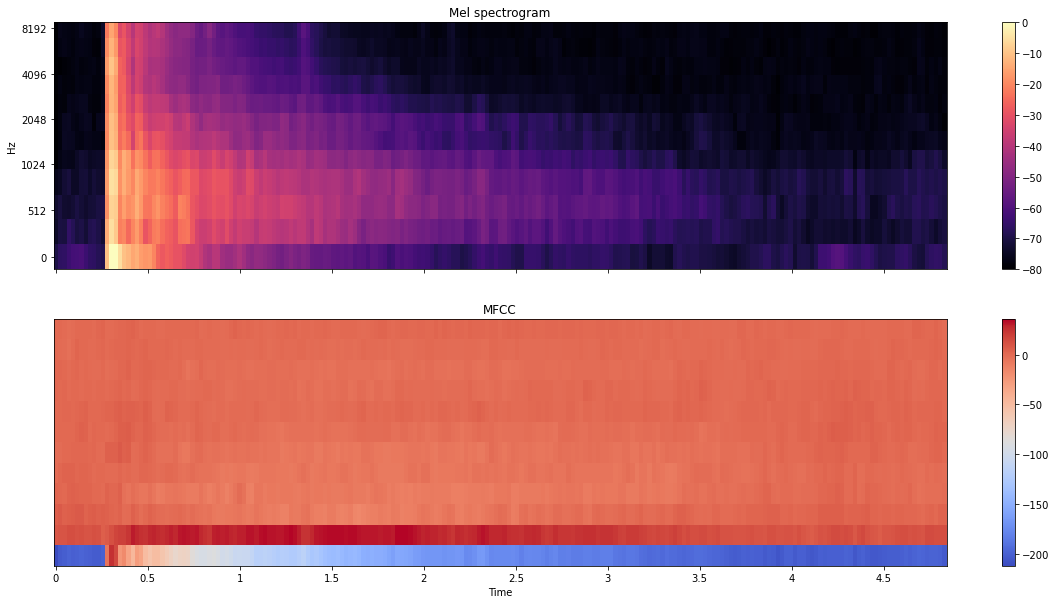

In [28]:
# Extraction de la feature LM
S = lisa.feature.melspectrogram(y=y_rsmple, sr=RATE, n_mels=N_MFCC, fmax=8000,center=True, pad_mode="linear_ramp")

# Extraction de la feature MFCC
mfccs = lisa.feature.mfcc(S=lisa.power_to_db(S))
#mfccs = lisa.feature.mfcc(y=y_rsmple, sr=RATE, n_mfcc=N_MFCC)

# Plot https://librosa.org/doc/main/generated/librosa.feature.mfcc.html
fig, ax = plt.subplots(nrows=2, sharex=True,figsize=(20,10))

img = lisa.display.specshow(lisa.power_to_db(S, ref=np.max), 
                            x_axis='time', y_axis='mel', fmax=8000, ax=ax[0])

fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = lisa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

### Fonction d'extraction

In [29]:
def load_wave(folder, file_name) :
    '''
    Chargement du fichier wave sans mono et sample rate
    qui seront normalisé plutard.
    
    :param folder: folder index
    :param file_name: file name
    :return: numpy array wave sound 
    '''
    path = '../input/urbansound8k/fold' + folder + '/' + file_name
    s, sr = lisa.load(path, sr=None, mono=False)
    
    return s

In [30]:
def extract_mfcc_features(wav,sr=RATE, n_mfcc=N_MFCC, mono=True, padding='linear_ramp'):
    '''
    Extraire la feature mfcc pour tout le data frame,
    Appliquera les normalisations de sample rate et mono
    
    :param wav: fichier wav chargé
    :param sr: sample rate,
    :param n_mfcc: nombre de filtre de mels
    :param mono: mono normalisation
    :param padding: padding mode
    :return: 2d numpy array MFCC
    '''
    y = wav
    # Normalisation des canaux à mono
    if mono : y = lisa.to_mono(y)
        
    # Normalization sample rate 
    y = lisa.core.resample(y=y_mono,orig_sr=sr,target_sr=RATE, scale=True)
    
    # Extraction de la feature LM
    S = lisa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mfcc, fmax=8000,center=True, pad_mode=padding)
    
    # Extraction de la feature MFCC 
    mfccs = lisa.feature.mfcc(S=lisa.power_to_db(S))
    
    return mfccs

In [31]:
def row_parser(row,sr=RATE, n_mfcc=N_MFCC, mono=True, padding='linear_ramp'):
    '''
    Parser chaque ligne en extrayant la feature mfcc du son
    et le label
    :exemple: l, f = row_parser(df.iloc[1])
    :return: label, mfcc feature(2d numpy array)
    '''
    folder = str(row['fold']);
    file_name = row['slice_file_name']
    label = row['classID']
    
    wave = load_wave(folder, file_name)
    mfccs = extract_mfcc_features(wave, sr, n_mfcc, mono, padding)
    
    return label, mfccs

In [32]:
def build_feature_df(df, n_mfcc=N_MFCC, mono=True, padding='linear_ramp'):
    '''
    Construire le dataframe avec les feature extraites.
    :param df: dataframe de base
    :param sr: sample rate,
    :param n_mfcc: nombre de filtre de mels
    :param mono: mono normalisation
    :param padding: padding mode
    
    Return
    -----
    
    X : les features extraite
    y : les labels
    df: composées des deux
    '''
    
    X, y = [], []
    headers = ''
    
    # Extraction des mfccs
    for index in trange(len(df)):
        l , mfccs = row_parser(df.iloc[index])

        X.append(mfccs)
        y.append(l)
    
    X = np.array(X)
    y_ = np.array(y)

    print('\nMFCC:\n Nombre de fenêtres =', X.shape[1])
    print(' Longueur de chaque caractéristique =', X.shape[2])
    
    # Entêtes pour le data frame
    for i in range(0, N_MFCC):
        headers += f' mfcc{i}'
    
    headers = headers.split()
    
    # On prend la moyenne des fenêtres
    X_ = np.mean(X.T,axis=0)
    
    # Creation du dataframe
    df_ = pd.DataFrame(X_.transpose(),columns=headers)
    
    # Ajout du target au data frame
    df_['target'] = y_
    
    print(f'X shape :{X_.shape}')
    print(f'y shape :{y_.shape}')
    
    return X_, y_, df_

In [33]:
X, y, df_new = build_feature_df(df)

  0%|          | 0/8732 [00:00<?, ?it/s]


MFCC:
 Nombre de fenêtres = 12
 Longueur de chaque caractéristique = 105
X shape :(12, 8732)
y shape :(8732,)


### Preparation du data frame

In [34]:
df_new

,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,target
0,-148.176239,9.839642,-13.770968,-0.406243,2.821182,3.951139,1.643202,3.636097,2.72867,0.866247,1.840712,0.285852,3
1,-148.176239,9.839642,-13.770968,-0.406243,2.821182,3.951139,1.643202,3.636097,2.72867,0.866247,1.840712,0.285852,2
2,-148.176239,9.839642,-13.770968,-0.406243,2.821182,3.951139,1.643202,3.636097,2.72867,0.866247,1.840712,0.285852,2
3,-148.176239,9.839642,-13.770968,-0.406243,2.821182,3.951139,1.643202,3.636097,2.72867,0.866247,1.840712,0.285852,2
4,-148.176239,9.839642,-13.770968,-0.406243,2.821182,3.951139,1.643202,3.636097,2.72867,0.866247,1.840712,0.285852,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,-148.176239,9.839642,-13.770968,-0.406243,2.821182,3.951139,1.643202,3.636097,2.72867,0.866247,1.840712,0.285852,1
8728,-148.176239,9.839642,-13.770968,-0.406243,2.821182,3.951139,1.643202,3.636097,2.72867,0.866247,1.840712,0.285852,1
8729,-148.176239,9.839642,-13.770968,-0.406243,2.821182,3.951139,1.643202,3.636097,2.72867,0.866247,1.840712,0.285852,1
8730,-148.176239,9.839642,-13.770968,-0.406243,2.821182,3.951139,1.643202,3.636097,2.72867,0.866247,1.840712,0.285852,1


## 12. Séparer les données en un jeu d'entraînement/validation et un jeu de test.

## 13. Premier réseau de neurones

## 14. Entraînement du modèle construit et mesurer sa performance.

## 15. Réseau de neurones convolutif (couches de convolution, couche de "pooling", "dropout", couches cachées complètement connectées)

## 16. Entraînement du modèle construit et mesurer sa performance.

## 17. Test de différentes structures et différentes valeurs des hyperparamètres

## 18. Meilleur modèle

**NOTES** :

* ...
* ...
* ...

## Acknowledgements

* J. Salamon, C. Jacoby and J. P. Bello, **"A Dataset and Taxonomy for Urban Sound Research"**, 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.
* Wikipedia contributors. (2023, January 5). WAV. Wikipedia. https://en.wikipedia.org/wiki/WAV
* Wikipedia contributors. (2023b, January 16). Waveform Audio File Format. https://fr.wikipedia.org/wiki/Waveform_Audio_File_Format
* Hwung, C. (2022, June 4). WAV Files: File Structure, Case Analysis and PCM Explained. https://www.videoproc.com/resource/wav-file.htm
* Sound - Frequency, Wavelength and Octave. (n.d.). https://www.engineeringtoolbox.com/sound-frequency-wavelength-d_56.html
* Amplitude : définition et explications. (n.d.). Techno-Science.net. https://www.techno-science.net/definition/1231.html
* V., M. (2022, June 28). What Is Sample Rate In Audio? ( Depths, Quality, Bit Rate ). Hip Hop Makers. https://hiphopmakers.com/what-is-sample-rate-in-audio
* Mel Spectrogram Explained with Python Code. (2022, June 10). Amir Masoud Sefidian. [link](http://sefidian.com/2022/03/24/mel-spectrogram-explained-with-python-code/#:~:text=A%20mel%20spectrogram%20is%20a%20spectrogram%20where,the%20frequencies%20are%20converted%20to%20the%20mel%20scale).
* Contributeurs aux projets Wikimedia. (2022, December 17). Échelle des mels. https://fr.wikipedia.org/wiki/%C3%89chelle_des_mels
* Contributeurs aux projets Wikimedia. (2022a, April 8). Spectrogramme. https://fr.wikipedia.org/wiki/Spectrogramme
* Min Xu; et al. (2004). ["HMM-based audio keyword generation"](https://web.archive.org/web/20070510193153/http://cemnet.ntu.edu.sg/home/asltchia/publication/AudioAnalysisUnderstanding/Conference/HMM-Based%20Audio%20Keyword%20Generation.pdf) . In Kiyoharu Aizawa; Yuichi Nakamura; Shin'ichi Satoh (eds.). Advances in Multimedia Information Processing – PCM 2004: 5th Pacific Rim Conference on Multimedia. Springer. ISBN 978-3-540-23985-7.
* Sahai, H. (n.d.). MFCC (Mel Frequency Cepstral Coefficients) for Audio format. OpenGenus IQ: Computing Expertise & Legacy. https://iq.opengenus.org/mfcc-audio/
* Inspired by [PRABHAV SINGH](https://www.kaggle.com/code/prabhavsingh/urbansound8k-classification/notebook)